# _Term Project_

## 260364 Applied Stat Model

### Team: Cookies and Friends

# Import Libraries and Declare Function

In [ ]:
library(olsrr)
library(caret)
library(pROC)

hosmerlem <-function (y, yhat, g = 10)
{
     cutyhat <- cut(yhat, breaks = quantile(yhat,
     probs = seq(0,1, 1/g)), include.lowest = T)
     obs <- xtabs(cbind(1 - y, y) ~ cutyhat)
     expect <- xtabs(cbind(1 - yhat, yhat) ~ cutyhat)
     chisq <- sum((obs - expect)^2/expect)
     P <- 1 - pchisq(chisq, g - 2)
     c("X^2" = chisq, Df = g - 2, "P(>Chi)" = P)
}


Attaching package: ‘olsrr’


The following object is masked from ‘package:datasets’:

    rivers


Loading required package: ggplot2

Loading required package: lattice

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




# Data Preparation

### Import data

In [ ]:
df <- read.csv("clean_data.csv", sep=",")
attach(df)

In [ ]:
head(df)
dim(df)

,PD,previous_credit_problem,gender,n_credits,occupation,n_dependents,telephone_registered,foreign_worker,age,current_account_with_money,⋯,duration_of_credit,business.consumption,saving_availability,employed,instalment_percent,guarantor_availability,duration_in_current_address,valuable_asset_availability,concurrent_credit_existence,free_housing
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,0,0,M,one,skilled,three_or_more,0,1,21,0,⋯,18,0,0,1,20.0,0,1,1,0,0
2,0,0,M,two_or_three,skilled,zero_to_two,0,1,36,0,⋯,9,0,0,1,30.0,0,1,0,0,0
3,0,0,M,one,unskilled,three_or_more,0,1,23,0,⋯,12,1,1,1,30.0,0,1,0,0,0
4,0,0,M,two_or_three,unskilled,zero_to_two,0,0,39,0,⋯,12,0,0,1,22.5,0,1,0,0,0
5,0,0,M,two_or_three,unskilled,three_or_more,0,0,38,0,⋯,12,0,0,1,20.0,0,1,1,1,1
6,0,0,M,two_or_three,unskilled,zero_to_two,0,0,48,0,⋯,10,0,0,1,35.0,0,1,0,0,0


[1] 1000   21

In [ ]:
names(df)

[1] "PD"                          "previous_credit_problem"    
 [3] "gender"                      "n_credits"                  
 [5] "occupation"                  "n_dependents"               
 [7] "telephone_registered"        "foreign_worker"             
 [9] "age"                         "current_account_with_money" 
[11] "credit_amount"               "duration_of_credit"         
[13] "business.consumption"        "saving_availability"        
[15] "employed"                    "instalment_percent"         
[17] "guarantor_availability"      "duration_in_current_address"
[19] "valuable_asset_availability" "concurrent_credit_existence"
[21] "free_housing"

### Variable Abbreviations

In [ ]:
col_dict <- list(
    PD = "PD",
    previous_credit_problem = "PCP",
    gender = "GEN",
    n_credits = "CRE",
    occupation = "OCC",
    n_dependents = "DEP",
    telephone_registered = "TEL",
    foreign_worker = "FRW",
    age = "AGE",
    current_account_with_money = "CAM",
    credit_amount = "CRA",
    duration_of_credit = "DUR",
    business.consumption = "BCO",
    saving_availability = "SAV",
    employed = "EMP",
    instalment_percent = "INS",
    guarantor_availability = "GUA",
    duration_in_current_address = "DCA",
    valuable_asset_availability = "VAA",
    concurrent_credit_existence = "CCE",
    free_housing = "FRE"
)

In [ ]:
for (col in names(col_dict)) {
    names(df)[names(df) == col] <- col_dict[col]
}

In [ ]:
names(df)

[1] "PD"  "PCP" "GEN" "CRE" "OCC" "DEP" "TEL" "FRW" "AGE" "CAM" "CRA" "DUR"
[13] "BCO" "SAV" "EMP" "INS" "GUA" "DCA" "VAA" "CCE" "FRE"

In [ ]:
head(df)

,PD,PCP,GEN,CRE,OCC,DEP,TEL,FRW,AGE,CAM,⋯,DUR,BCO,SAV,EMP,INS,GUA,DCA,VAA,CCE,FRE
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,0,0,M,one,skilled,three_or_more,0,1,21,0,⋯,18,0,0,1,20.0,0,1,1,0,0
2,0,0,M,two_or_three,skilled,zero_to_two,0,1,36,0,⋯,9,0,0,1,30.0,0,1,0,0,0
3,0,0,M,one,unskilled,three_or_more,0,1,23,0,⋯,12,1,1,1,30.0,0,1,0,0,0
4,0,0,M,two_or_three,unskilled,zero_to_two,0,0,39,0,⋯,12,0,0,1,22.5,0,1,0,0,0
5,0,0,M,two_or_three,unskilled,three_or_more,0,0,38,0,⋯,12,0,0,1,20.0,0,1,1,1,1
6,0,0,M,two_or_three,unskilled,zero_to_two,0,0,48,0,⋯,10,0,0,1,35.0,0,1,0,0,0


In [ ]:
print(paste0("Good Credit: ", sum(df$PD == 0)))
print(paste0("Bad Credit: ", sum(df$PD == 1)))

[1] "Good Credit: 700"
[1] "Bad Credit: 300"


# Experimental Setting

### Influence Diagnostics

In [ ]:
full_model <- glm(PD ~ ., data = df, family=binomial(link="logit"))
summary(full_model)


Call:
glm(formula = PD ~ ., family = binomial(link = "logit"), data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8244  -0.7684  -0.4611   0.8662   2.6488  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -6.640e-01  1.093e+00  -0.607 0.543628    
PCP              9.570e-01  2.714e-01   3.526 0.000422 ***
GENM             3.362e-02  2.783e-01   0.121 0.903840    
CREone           3.518e-01  5.445e-01   0.646 0.518145    
CREsix_or_more   4.770e-01  1.110e+00   0.430 0.667300    
CREtwo_or_three  2.184e-01  5.507e-01   0.397 0.691631    
OCCskilled       8.793e-02  2.631e-01   0.334 0.738235    
OCCunemployed   -1.402e-03  6.106e-01  -0.002 0.998168    
OCCunskilled     1.097e-01  3.215e-01   0.341 0.733004    
DEPzero_to_two   7.364e-02  2.270e-01   0.324 0.745674    
TEL             -3.247e-01  1.867e-01  -1.739 0.082077 .  
FRW              1.333e+00  6.104e-01   2.184 0.028979 *  
AGE             -1.384e-02  7

#### Outlying X Detection (leverage)

[1] "the leverage cutoff is  0.05"


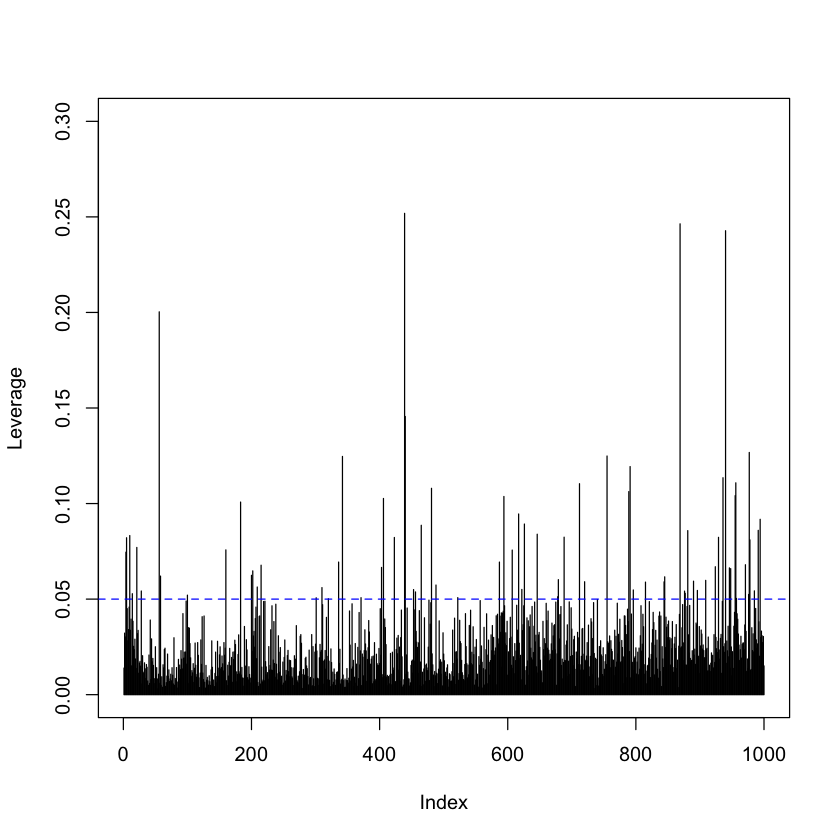

In [ ]:
h <- hatvalues(full_model)
cutoff <- 2 * full_model$rank / nrow(df)
par(bg = "white")
plot(h, ylab = "Leverage", ylim=c(0,0.3), type="h")
abline(h=cutoff, col="blue", lty=2)
print(paste("the leverage cutoff is ", cutoff))

In [ ]:
print("Outlier for X")
outlier_x_idx <- which(h > cutoff)
df[outlier_x_idx,]

[1] "Outlier for X"


,PD,PCP,GEN,CRE,OCC,DEP,TEL,FRW,AGE,CAM,⋯,DUR,BCO,SAV,EMP,INS,GUA,DCA,VAA,CCE,FRE
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>
4,0,0,M,two_or_three,unskilled,zero_to_two,0,0,39,0,⋯,12,0,0,1,22.5,0,1,0,0,0
5,0,0,M,two_or_three,unskilled,three_or_more,0,0,38,0,⋯,12,0,0,1,20.0,0,1,1,1,1
10,0,0,M,one,unemployed,three_or_more,0,1,23,0,⋯,24,0,1,0,35.0,0,1,1,0,0
14,0,0,M,one,executive,three_or_more,1,1,31,0,⋯,48,1,1,0,30.0,0,1,1,0,1
21,0,0,M,four_or_five,skilled,zero_to_two,0,1,37,0,⋯,6,0,0,1,35.0,0,1,0,0,0
28,0,0,M,four_or_five,unskilled,three_or_more,0,1,37,0,⋯,9,0,0,1,30.0,0,1,0,0,1
56,0,0,M,six_or_more,unskilled,three_or_more,1,1,58,0,⋯,12,0,0,1,20.0,0,1,0,0,1
58,0,0,F,one,skilled,three_or_more,0,0,27,0,⋯,15,0,0,1,20.0,0,1,0,0,1
100,0,0,M,two_or_three,unskilled,three_or_more,0,1,41,0,⋯,42,1,0,1,30.0,0,0,0,1,1


#### Outlying Y Detection (External Deteled Residuals)

[1] "the cutoff is  4.07386228147593"


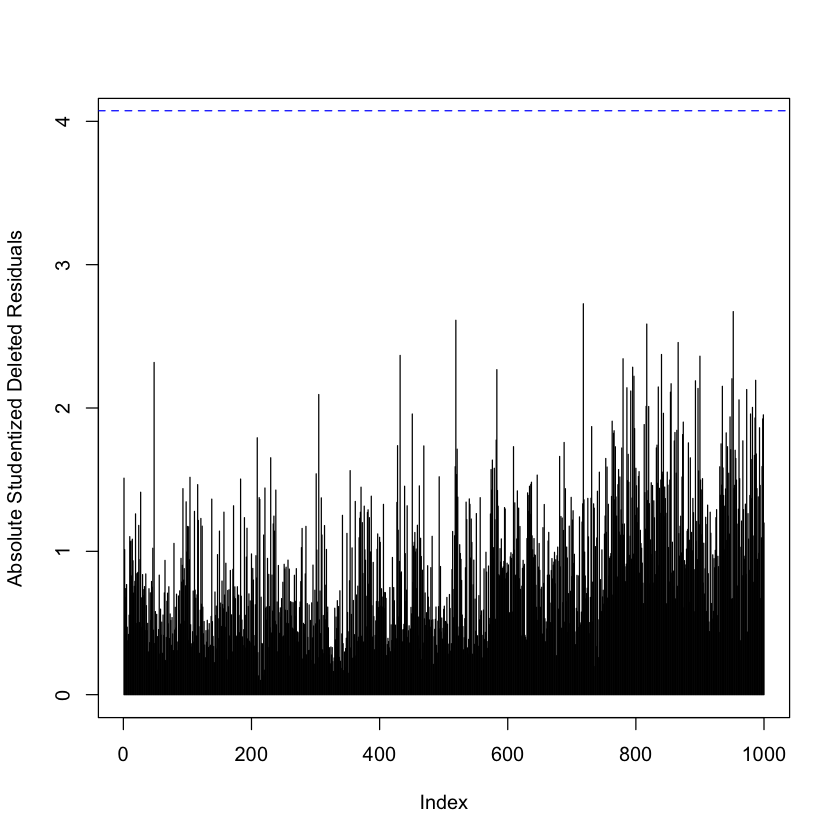

In [ ]:
n <- nrow(df)
alpha <- 0.05
ext_res <- rstudent(full_model)
par(bg = "white")
plot(abs(ext_res), ylab="Absolute Studentized Deleted Residuals", ylim=c(0,4), type="h")
cutoff<-qt(1-alpha/(2*n), full_model$df.residual-1)
abline(h=cutoff, col="blue", lty=2)
print(paste("the cutoff is ", cutoff))

In [ ]:
print("Outlier for Y")
outlier_y_idx <- which(abs(ext_res) > cutoff)
df[outlier_y_idx,]

[1] "Outlier for Y"


Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


PD,PCP,GEN,CRE,OCC,DEP,TEL,FRW,AGE,CAM,⋯,DUR,BCO,SAV,EMP,INS,GUA,DCA,VAA,CCE,FRE
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>


In [ ]:
# outlier indices
outlier_idx <- c(outlier_x_idx, outlier_y_idx)

#### Cook's Distance

In [ ]:
influ_table <- data.frame(Cooks.D=cooks.distance(full_model)[outlier_idx])
influ_table$`Cooks.D > 4/n` <- influ_table$Cooks.D > 4/nrow(df)
influ_table

,Cooks.D,Cooks.D > 4/n
,<dbl>,<lgl>
4,0.0008588323,FALSE
5,0.0012621749,FALSE
10,0.0030618985,FALSE
14,0.0017954351,FALSE
21,0.0014597046,FALSE
28,0.0005999377,FALSE
56,0.0044360839,TRUE
58,0.0005290822,FALSE
100,0.0021792400,FALSE


In [ ]:
print(paste0("No of influential points: ", sum(influ_table$`Cooks.D > 4/n` == TRUE)))
ip_idx <- which(influ_table$`Cooks.D > 4/n` == TRUE)

[1] "No of influential points: 28"


#### Remove Influential Data

In [ ]:
new_df = df[-c(ip_idx),]
dim(new_df)
print(paste0("Good Credit: ", sum(new_df$PD == 0)))
print(paste0("Bad Credit: ", sum(new_df$PD == 1)))

[1] 972  21

[1] "Good Credit: 674"
[1] "Bad Credit: 298"


### Data Splitting (Stratified Train/Test Splitting)

In [ ]:
set.seed(1)
train_index <- createDataPartition(new_df$PD, p = .8, list = FALSE)
train_df <- new_df[ train_index,]
test_df  <- new_df[-train_index,]
dim(train_df)
print(paste0("Good Credit: ", sum(train_df$PD == 0)))
print(paste0("Bad Credit: ", sum(train_df$PD == 1)))
dim(test_df)
print(paste0("Good Credit: ", sum(test_df$PD == 0)))
print(paste0("Bad Credit: ", sum(test_df$PD == 1)))

[1] 778  21

[1] "Good Credit: 529"
[1] "Bad Credit: 249"


[1] 194  21

[1] "Good Credit: 145"
[1] "Bad Credit: 49"


# Experiment

## 0. Fit full model by training set

In [ ]:
full_model <- glm(PD ~ ., data = train_df, family=binomial(link="logit"))
summary(full_model)


Call:
glm(formula = PD ~ ., family = binomial(link = "logit"), data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9276  -0.7882  -0.4783   0.8896   2.5896  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -3.733e-01  1.212e+00  -0.308 0.758068    
PCP              9.353e-01  3.065e-01   3.052 0.002276 ** 
GENM             4.401e-02  3.175e-01   0.139 0.889749    
CREone           3.816e-01  6.042e-01   0.632 0.527682    
CREsix_or_more   4.616e-01  1.138e+00   0.406 0.684997    
CREtwo_or_three  2.722e-01  6.121e-01   0.445 0.656606    
OCCskilled       3.066e-01  3.041e-01   1.008 0.313308    
OCCunemployed   -2.444e-01  7.142e-01  -0.342 0.732188    
OCCunskilled     1.975e-01  3.682e-01   0.537 0.591611    
DEPzero_to_two   2.751e-01  2.465e-01   1.116 0.264539    
TEL             -4.066e-01  2.119e-01  -1.919 0.055002 .  
FRW              1.040e+00  6.278e-01   1.656 0.097630 .  
AGE             -1.151e

In [ ]:
hosmerlem(train_df$PD, full_model$fitted.values)

X^2        Df   P(>Chi) 
4.6436865 8.0000000 0.7948915

In [ ]:
pred_model = glm(
    PD ~ .,
    family = binomial(link = "logit"),
    data = train_df
)

In [ ]:
pred_prob <- predict(pred_model, test_df, type = "response")
pred_class <- rep(0, nrow(test_df))
# Use 0.5 as cutoff point
pred_class[pred_prob>=0.5]<-1
truth_class <- test_df$PD
xtab <- table(pred_class, truth_class)
xtab

          truth_class
pred_class   0   1
         0 129  31
         1  16  18

In [ ]:
print(paste0("Sensitivity: ", sensitivity(xtab)))

[1] "Sensitivity: 0.889655172413793"


In [ ]:
print(paste0("Specificity: ", specificity(xtab)))

[1] "Specificity: 0.36734693877551"


Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = truth_class, predictor = pred_prob, plot = TRUE)

Data: pred_prob in 145 controls (truth_class 0) < 49 cases (truth_class 1).
Area under the curve: 0.7682

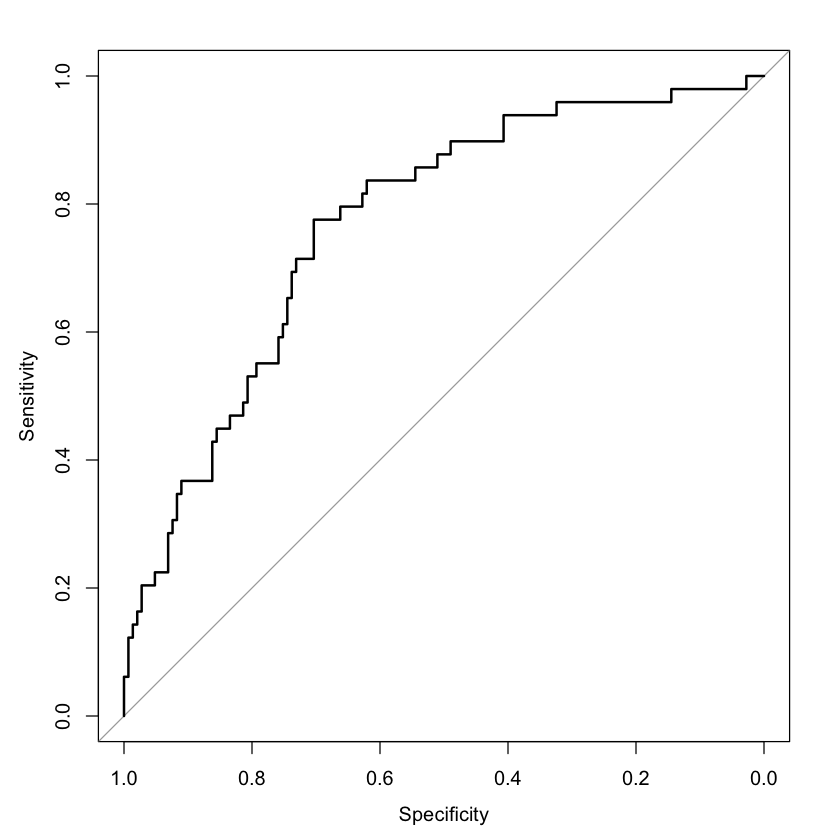

In [ ]:
par(bg = "white")
roc(truth_class, pred_prob, plot = TRUE)

In [ ]:
roc_obj <- roc(truth_class, pred_prob)
cc <- coords(roc_obj, "best", best.method="youden")
youden_index = cc$threshold
youden_index

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 0.3232269

In [ ]:
pred_class <- rep(0, nrow(test_df))
pred_class[pred_prob>=youden_index]<-1
truth <- test_df$PD
xtab <- table(pred_class, truth)
xtab

          truth
pred_class   0   1
         0 102  11
         1  43  38

In [ ]:
confusionMatrix(xtab)[4]$byClass[['F1']]

[1] 0.7906977

In [ ]:
sensitivity(xtab)
specificity(xtab)
confusionMatrix(xtab)[3]$overall[1][['Accuracy']]

[1] 0.7034483

[1] 0.7755102

[1] 0.7216495

In [ ]:
full_result = data.frame(
    Approach = c("Full"),
    # Accuracy = confusionMatrix(xtab)[3]$overall[1][['Accuracy']],
    Bal_Accuracy = confusionMatrix(xtab)[4]$byClass[['Balanced Accuracy']],
    Sensitivity = c(sensitivity(xtab)),
    Specificity = c(specificity(xtab)),
    F1 = confusionMatrix(xtab)[4]$byClass[['F1']],
    AUC = c(auc(truth_class, pred_prob))
)
full_result

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Approach,Bal_Accuracy,Sensitivity,Specificity,F1,AUC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Full,0.7394792,0.7034483,0.7755102,0.7906977,0.7681914


## 1. Backward Stepwise Selection (AIC)

### Model Selection

In [ ]:
best_model <- step(full_model)
summary(best_model)

Start:  AIC=841.34
PD ~ PCP + GEN + CRE + OCC + DEP + TEL + FRW + AGE + CAM + CRA + 
    DUR + BCO + SAV + EMP + INS + GUA + DCA + VAA + CCE + FRE

       Df Deviance    AIC
- CRE   3   792.01 836.01
- OCC   3   792.83 836.83
- GEN   1   791.36 839.36
- BCO   1   791.39 839.39
- GUA   1   791.89 839.89
- DCA   1   792.19 840.19
- DEP   1   792.58 840.58
- EMP   1   793.00 841.00
- VAA   1   793.05 841.05
- AGE   1   793.19 841.19
<none>      791.34 841.34
- FRW   1   794.55 842.55
- TEL   1   795.08 843.08
- CRA   1   796.25 844.25
- CCE   1   796.72 844.72
- FRE   1   796.92 844.92
- DUR   1   796.98 844.98
- INS   1   798.66 846.66
- PCP   1   800.87 848.87
- SAV   1   806.88 854.88
- CAM   1   843.09 891.09

Step:  AIC=836.01
PD ~ PCP + GEN + OCC + DEP + TEL + FRW + AGE + CAM + CRA + DUR + 
    BCO + SAV + EMP + INS + GUA + DCA + VAA + CCE + FRE

       Df Deviance    AIC
- OCC   3   793.48 831.48
- GEN   1   792.03 834.03
- BCO   1   792.10 834.10
- GUA   1   792.59 834.59
- DCA   


Call:
glm(formula = PD ~ PCP + TEL + FRW + CAM + CRA + DUR + SAV + 
    INS + VAA + CCE + FRE, family = binomial(link = "logit"), 
    data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8297  -0.8116  -0.4930   0.9184   2.5185  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.074e-01  7.795e-01  -0.779 0.435863    
PCP          9.368e-01  3.005e-01   3.118 0.001822 ** 
TEL         -4.764e-01  1.932e-01  -2.466 0.013659 *  
FRW          1.106e+00  6.239e-01   1.773 0.076290 .  
CAM         -1.345e+00  1.910e-01  -7.039 1.93e-12 ***
CRA          8.795e-05  4.289e-05   2.051 0.040290 *  
DUR          2.389e-02  9.270e-03   2.578 0.009951 ** 
SAV         -6.866e-01  1.877e-01  -3.659 0.000254 ***
INS         -4.380e-02  1.727e-02  -2.537 0.011180 *  
VAA          3.439e-01  2.100e-01   1.638 0.101435    
CCE          4.891e-01  2.160e-01   2.264 0.023549 *  
FRE         -6.127e-01  2.237e-01  -2.739 0.006163 ** 
---

### Model Diagnostics

#### Goodness of Fit (Hosmer-Lemeshow Test)

In [ ]:
hosmerlem(train_df$PD, full_model$fitted.values)

X^2        Df   P(>Chi) 
4.6436865 8.0000000 0.7948915

In [ ]:
hosmerlem(train_df$PD, best_model$fitted.values)

X^2        Df   P(>Chi) 
2.9782871 8.0000000 0.9357127

#### Drop in deviance

In [ ]:
pchisq(deviance(best_model)-deviance(full_model), df = 13, lower=F)

[1] 0.8991793

#### Overdispersion (Quasi-likelihood)

In [ ]:
# quasi-likelihood
est.phi <- function(glmobj) {
    sum(residuals(glmobj, type="pearson")^2)/df.residual(glmobj)
}
est.phi(best_model)

[1] 1.019979

### Prediction and Evaluation

In [ ]:
pred_model = glm(
    PD ~ PCP + TEL + FRW + CAM + CRA + DUR + SAV + 
    INS + VAA + CCE + FRE,
    family = binomial(link = "logit"),
    data = train_df
)
summary(pred_model)


Call:
glm(formula = PD ~ PCP + TEL + FRW + CAM + CRA + DUR + SAV + 
    INS + VAA + CCE + FRE, family = binomial(link = "logit"), 
    data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8297  -0.8116  -0.4930   0.9184   2.5185  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.074e-01  7.795e-01  -0.779 0.435863    
PCP          9.368e-01  3.005e-01   3.118 0.001822 ** 
TEL         -4.764e-01  1.932e-01  -2.466 0.013659 *  
FRW          1.106e+00  6.239e-01   1.773 0.076290 .  
CAM         -1.345e+00  1.910e-01  -7.039 1.93e-12 ***
CRA          8.795e-05  4.289e-05   2.051 0.040290 *  
DUR          2.389e-02  9.270e-03   2.578 0.009951 ** 
SAV         -6.866e-01  1.877e-01  -3.659 0.000254 ***
INS         -4.380e-02  1.727e-02  -2.537 0.011180 *  
VAA          3.439e-01  2.100e-01   1.638 0.101435    
CCE          4.891e-01  2.160e-01   2.264 0.023549 *  
FRE         -6.127e-01  2.237e-01  -2.739 0.006163 ** 
---

In [ ]:
pred_prob <- predict(pred_model, test_df, type = "response")
pred_class <- rep(0, nrow(test_df))
# Use 0.5 as cutoff point
pred_class[pred_prob>=0.5]<-1
truth_class <- test_df$PD
xtab <- table(pred_class, truth_class)
xtab

          truth_class
pred_class   0   1
         0 130  29
         1  15  20

In [ ]:
print(paste0("Sensitivity: ", sensitivity(xtab)))

[1] "Sensitivity: 0.896551724137931"


In [ ]:
print(paste0("Specificity: ", specificity(xtab)))

[1] "Specificity: 0.408163265306122"


Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = truth_class, predictor = pred_prob, plot = TRUE)

Data: pred_prob in 145 controls (truth_class 0) < 49 cases (truth_class 1).
Area under the curve: 0.7714

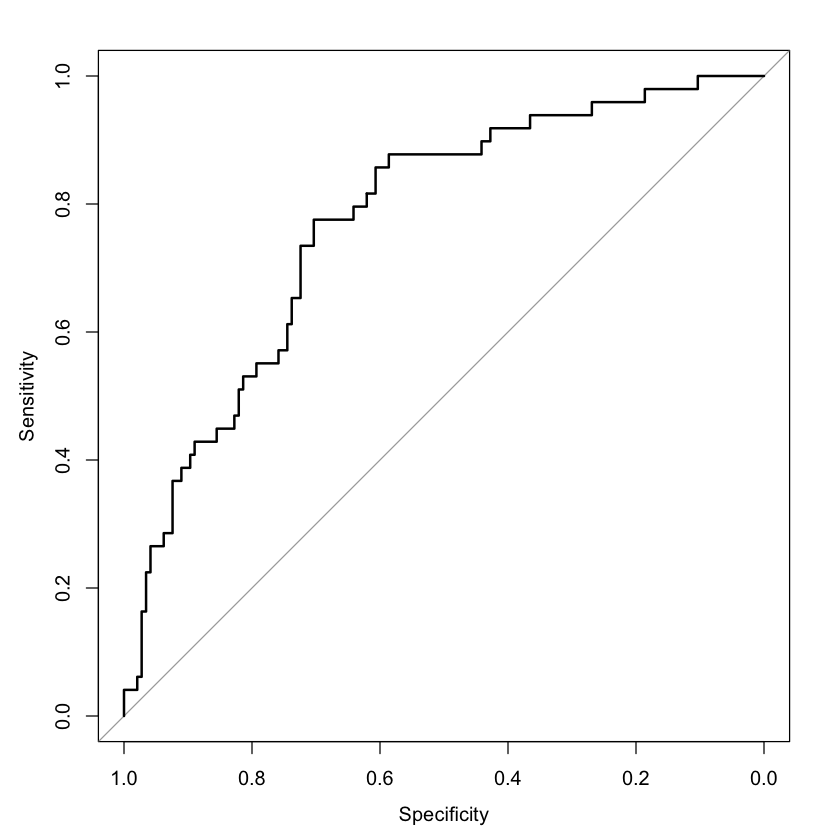

In [ ]:
par(bg = "white")
roc(truth_class, pred_prob, plot = TRUE)

In [ ]:
roc_obj <- roc(truth_class, pred_prob)
cc <- coords(roc_obj, "best", best.method="youden")
youden_index = cc$threshold
youden_index

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 0.325844

In [ ]:
pred_class <- rep(0, nrow(test_df))
pred_class[pred_prob>=youden_index]<-1
truth <- test_df$PD
xtab <- table(pred_class, truth)
xtab

          truth
pred_class   0   1
         0 102  11
         1  43  38

In [ ]:
sensitivity(xtab)
specificity(xtab)
confusionMatrix(xtab)[3]$overall[1][['Accuracy']]

[1] 0.7034483

[1] 0.7755102

[1] 0.7216495

In [ ]:
aic_result = data.frame(
    Approach = c("AIC"),
    # Accuracy = confusionMatrix(xtab)[3]$overall[1][['Accuracy']],
    Bal_Accuracy = confusionMatrix(xtab)[4]$byClass[['Balanced Accuracy']],
    Sensitivity = c(sensitivity(xtab)),
    Specificity = c(specificity(xtab)),
    F1 = confusionMatrix(xtab)[4]$byClass[['F1']],
    AUC = c(auc(truth_class, pred_prob))
)
aic_result

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Approach,Bal_Accuracy,Sensitivity,Specificity,F1,AUC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AIC,0.7394792,0.7034483,0.7755102,0.7906977,0.7714286


## 2. Backward Elimination (Wald's Test with p-value cutoff = 0.05)

### Model Selection

In [ ]:
reduced_model <- update(full_model, PD ~ . - GEN, data = train_df)
summary(reduced_model)


Call:
glm(formula = PD ~ PCP + CRE + OCC + DEP + TEL + FRW + AGE + 
    CAM + CRA + DUR + BCO + SAV + EMP + INS + GUA + DCA + VAA + 
    CCE + FRE, family = binomial(link = "logit"), data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9298  -0.7922  -0.4775   0.8914   2.5770  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -3.446e-01  1.194e+00  -0.289 0.772924    
PCP              9.380e-01  3.059e-01   3.066 0.002169 ** 
CREone           3.826e-01  6.045e-01   0.633 0.526741    
CREsix_or_more   4.661e-01  1.138e+00   0.410 0.682005    
CREtwo_or_three  2.738e-01  6.124e-01   0.447 0.654829    
OCCskilled       3.055e-01  3.040e-01   1.005 0.314891    
OCCunemployed   -2.463e-01  7.142e-01  -0.345 0.730213    
OCCunskilled     1.957e-01  3.679e-01   0.532 0.594805    
DEPzero_to_two   2.784e-01  2.454e-01   1.134 0.256695    
TEL             -4.075e-01  2.118e-01  -1.924 0.054384 .  
FRW              1.04

In [ ]:
reduced_model <- update(reduced_model, PD ~ . - BCO, data = train_df)
summary(reduced_model)


Call:
glm(formula = PD ~ PCP + CRE + OCC + DEP + TEL + FRW + AGE + 
    CAM + CRA + DUR + SAV + EMP + INS + GUA + DCA + VAA + CCE + 
    FRE, family = binomial(link = "logit"), data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9198  -0.7891  -0.4768   0.8948   2.5789  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -3.443e-01  1.195e+00  -0.288  0.77315    
PCP              9.289e-01  3.036e-01   3.060  0.00221 ** 
CREone           3.856e-01  6.045e-01   0.638  0.52353    
CREsix_or_more   4.633e-01  1.139e+00   0.407  0.68433    
CREtwo_or_three  2.716e-01  6.125e-01   0.443  0.65741    
OCCskilled       3.096e-01  3.037e-01   1.020  0.30788    
OCCunemployed   -2.552e-01  7.130e-01  -0.358  0.72040    
OCCunskilled     1.967e-01  3.680e-01   0.535  0.59288    
DEPzero_to_two   2.766e-01  2.453e-01   1.128  0.25942    
TEL             -4.105e-01  2.113e-01  -1.942  0.05209 .  
FRW              1.042e+00 

In [ ]:
reduced_model <- update(reduced_model, PD ~ . - CRE, data = train_df)
summary(reduced_model)


Call:
glm(formula = PD ~ PCP + OCC + DEP + TEL + FRW + AGE + CAM + 
    CRA + DUR + SAV + EMP + INS + GUA + DCA + VAA + CCE + FRE, 
    family = binomial(link = "logit"), data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8878  -0.8016  -0.4757   0.8954   2.4922  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     7.859e-02  1.006e+00   0.078 0.937740    
PCP             9.232e-01  3.023e-01   3.054 0.002254 ** 
OCCskilled      2.895e-01  3.021e-01   0.958 0.337914    
OCCunemployed  -3.274e-01  7.058e-01  -0.464 0.642770    
OCCunskilled    1.798e-01  3.669e-01   0.490 0.624114    
DEPzero_to_two  2.616e-01  2.432e-01   1.075 0.282160    
TEL            -4.282e-01  2.095e-01  -2.044 0.040938 *  
FRW             1.032e+00  6.290e-01   1.641 0.100832    
AGE            -1.209e-02  8.427e-03  -1.434 0.151520    
CAM            -1.354e+00  1.932e-01  -7.011 2.37e-12 ***
CRA             9.819e-05  4.497e-05   2.183

In [ ]:
reduced_model <- update(reduced_model, PD ~ . - OCC, data = train_df)
summary(reduced_model)


Call:
glm(formula = PD ~ PCP + DEP + TEL + FRW + AGE + CAM + CRA + 
    DUR + SAV + EMP + INS + GUA + DCA + VAA + CCE + FRE, family = binomial(link = "logit"), 
    data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8440  -0.8023  -0.4749   0.9056   2.5171  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     4.175e-02  9.779e-01   0.043  0.96595    
PCP             9.161e-01  3.004e-01   3.050  0.00229 ** 
DEPzero_to_two  2.521e-01  2.414e-01   1.044  0.29636    
TEL            -4.629e-01  1.971e-01  -2.348  0.01888 *  
FRW             1.047e+00  6.290e-01   1.664  0.09612 .  
AGE            -1.297e-02  8.379e-03  -1.547  0.12176    
CAM            -1.352e+00  1.927e-01  -7.017 2.26e-12 ***
CRA             8.923e-05  4.314e-05   2.068  0.03860 *  
DUR             2.378e-02  9.362e-03   2.540  0.01108 *  
SAV            -7.130e-01  1.897e-01  -3.759  0.00017 ***
EMP            -3.221e-01  3.609e-01  -0.892  0.37

In [ ]:
reduced_model <- update(reduced_model, PD ~ . - GUA, data = train_df)
summary(reduced_model)


Call:
glm(formula = PD ~ PCP + DEP + TEL + FRW + AGE + CAM + CRA + 
    DUR + SAV + EMP + INS + DCA + VAA + CCE + FRE, family = binomial(link = "logit"), 
    data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8908  -0.8021  -0.4768   0.9118   2.5128  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -8.374e-02  9.619e-01  -0.087 0.930623    
PCP             9.177e-01  3.005e-01   3.054 0.002257 ** 
DEPzero_to_two  2.512e-01  2.413e-01   1.041 0.297835    
TEL            -4.604e-01  1.971e-01  -2.336 0.019499 *  
FRW             1.102e+00  6.238e-01   1.766 0.077406 .  
AGE            -1.287e-02  8.373e-03  -1.538 0.124168    
CAM            -1.345e+00  1.923e-01  -6.994 2.67e-12 ***
CRA             8.733e-05  4.305e-05   2.028 0.042509 *  
DUR             2.378e-02  9.365e-03   2.539 0.011119 *  
SAV            -7.002e-01  1.888e-01  -3.708 0.000209 ***
EMP            -3.127e-01  3.611e-01  -0.866 0.386476   

In [ ]:
reduced_model <- update(reduced_model, PD ~ . - EMP, data = train_df)
summary(reduced_model)


Call:
glm(formula = PD ~ PCP + DEP + TEL + FRW + AGE + CAM + CRA + 
    DUR + SAV + INS + DCA + VAA + CCE + FRE, family = binomial(link = "logit"), 
    data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7727  -0.8100  -0.4760   0.9085   2.4959  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -4.483e-01  8.647e-01  -0.518  0.60417    
PCP             9.246e-01  3.001e-01   3.081  0.00206 ** 
DEPzero_to_two  2.449e-01  2.408e-01   1.017  0.30926    
TEL            -4.453e-01  1.960e-01  -2.272  0.02310 *  
FRW             1.127e+00  6.237e-01   1.807  0.07081 .  
AGE            -1.205e-02  8.330e-03  -1.446  0.14819    
CAM            -1.356e+00  1.919e-01  -7.067 1.59e-12 ***
CRA             9.060e-05  4.295e-05   2.109  0.03491 *  
DUR             2.283e-02  9.297e-03   2.455  0.01408 *  
SAV            -7.020e-01  1.888e-01  -3.719  0.00020 ***
INS            -4.554e-02  1.741e-02  -2.615  0.00892 ** 
DCA 

In [ ]:
reduced_model <- update(reduced_model, PD ~ . - DCA, data = train_df)
summary(reduced_model)


Call:
glm(formula = PD ~ PCP + DEP + TEL + FRW + AGE + CAM + CRA + 
    DUR + SAV + INS + VAA + CCE + FRE, family = binomial(link = "logit"), 
    data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7636  -0.8062  -0.4727   0.9119   2.4869  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -2.359e-01  8.304e-01  -0.284 0.776350    
PCP             9.159e-01  2.998e-01   3.055 0.002252 ** 
DEPzero_to_two  2.565e-01  2.400e-01   1.069 0.285209    
TEL            -4.388e-01  1.957e-01  -2.242 0.024937 *  
FRW             1.115e+00  6.235e-01   1.788 0.073767 .  
AGE            -1.109e-02  8.249e-03  -1.345 0.178781    
CAM            -1.347e+00  1.915e-01  -7.035 1.99e-12 ***
CRA             9.212e-05  4.286e-05   2.149 0.031611 *  
DUR             2.274e-02  9.276e-03   2.451 0.014245 *  
SAV            -6.924e-01  1.883e-01  -3.677 0.000236 ***
INS            -4.648e-02  1.737e-02  -2.676 0.007446 ** 
VAA       

In [ ]:
reduced_model <- update(reduced_model, PD ~ . - DEP, data = train_df)
summary(reduced_model)


Call:
glm(formula = PD ~ PCP + TEL + FRW + AGE + CAM + CRA + DUR + 
    SAV + INS + VAA + CCE + FRE, family = binomial(link = "logit"), 
    data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7882  -0.8039  -0.4800   0.9306   2.5222  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.546e-01  8.317e-01  -0.306 0.759463    
PCP          9.336e-01  3.001e-01   3.111 0.001864 ** 
TEL         -4.414e-01  1.953e-01  -2.260 0.023794 *  
FRW          1.089e+00  6.265e-01   1.738 0.082282 .  
AGE         -1.002e-02  8.140e-03  -1.231 0.218443    
CAM         -1.344e+00  1.912e-01  -7.026 2.12e-12 ***
CRA          9.069e-05  4.284e-05   2.117 0.034241 *  
DUR          2.315e-02  9.268e-03   2.498 0.012493 *  
SAV         -6.864e-01  1.879e-01  -3.653 0.000259 ***
INS         -4.563e-02  1.734e-02  -2.632 0.008493 ** 
VAA          3.412e-01  2.104e-01   1.622 0.104818    
CCE          4.987e-01  2.164e-01   2.304 0.021222 *

In [ ]:
reduced_model <- update(reduced_model, PD ~ . - AGE, data = train_df)
summary(reduced_model)


Call:
glm(formula = PD ~ PCP + TEL + FRW + CAM + CRA + DUR + SAV + 
    INS + VAA + CCE + FRE, family = binomial(link = "logit"), 
    data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8297  -0.8116  -0.4930   0.9184   2.5185  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.074e-01  7.795e-01  -0.779 0.435863    
PCP          9.368e-01  3.005e-01   3.118 0.001822 ** 
TEL         -4.764e-01  1.932e-01  -2.466 0.013659 *  
FRW          1.106e+00  6.239e-01   1.773 0.076290 .  
CAM         -1.345e+00  1.910e-01  -7.039 1.93e-12 ***
CRA          8.795e-05  4.289e-05   2.051 0.040290 *  
DUR          2.389e-02  9.270e-03   2.578 0.009951 ** 
SAV         -6.866e-01  1.877e-01  -3.659 0.000254 ***
INS         -4.380e-02  1.727e-02  -2.537 0.011180 *  
VAA          3.439e-01  2.100e-01   1.638 0.101435    
CCE          4.891e-01  2.160e-01   2.264 0.023549 *  
FRE         -6.127e-01  2.237e-01  -2.739 0.006163 ** 
---

In [ ]:
reduced_model <- update(reduced_model, PD ~ . - VAA, data = train_df)
summary(reduced_model)


Call:
glm(formula = PD ~ PCP + TEL + FRW + CAM + CRA + DUR + SAV + 
    INS + CCE + FRE, family = binomial(link = "logit"), data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8353  -0.8218  -0.4885   0.9405   2.5209  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.610e-01  7.711e-01  -0.598 0.549902    
PCP          9.461e-01  2.988e-01   3.166 0.001544 ** 
TEL         -4.468e-01  1.921e-01  -2.326 0.020040 *  
FRW          1.161e+00  6.196e-01   1.874 0.060869 .  
CAM         -1.355e+00  1.909e-01  -7.099 1.25e-12 ***
CRA          9.605e-05  4.261e-05   2.254 0.024203 *  
DUR          2.521e-02  9.206e-03   2.738 0.006184 ** 
SAV         -6.784e-01  1.873e-01  -3.621 0.000293 ***
INS         -4.483e-02  1.723e-02  -2.601 0.009289 ** 
CCE          5.018e-01  2.158e-01   2.325 0.020051 *  
FRE         -6.041e-01  2.230e-01  -2.708 0.006761 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(

In [ ]:
best_model <- update(reduced_model, PD ~ . - FRW, data = train_df)
summary(best_model)


Call:
glm(formula = PD ~ PCP + TEL + CAM + CRA + DUR + SAV + INS + 
    CCE + FRE, family = binomial(link = "logit"), data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8373  -0.8260  -0.4971   0.9397   2.5351  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.158e-01  5.069e-01   1.215 0.224447    
PCP          9.657e-01  2.992e-01   3.227 0.001250 ** 
TEL         -4.273e-01  1.917e-01  -2.229 0.025827 *  
CAM         -1.336e+00  1.904e-01  -7.019 2.23e-12 ***
CRA          9.082e-05  4.274e-05   2.125 0.033583 *  
DUR          2.721e-02  9.151e-03   2.973 0.002948 ** 
SAV         -6.749e-01  1.868e-01  -3.612 0.000304 ***
INS         -4.511e-02  1.720e-02  -2.622 0.008742 ** 
CCE          5.049e-01  2.159e-01   2.339 0.019351 *  
FRE         -5.829e-01  2.217e-01  -2.629 0.008569 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    

### Model Diagnostics

#### Goodness of Fit (Hosmer-Lemeshow Test)

In [ ]:
hosmerlem <-function (y, yhat, g = 10)
{
     cutyhat <- cut(yhat, breaks = quantile(yhat,
     probs = seq(0,1, 1/g)), include.lowest = T)
     obs <- xtabs(cbind(1 - y, y) ~ cutyhat)
     expect <- xtabs(cbind(1 - yhat, yhat) ~ cutyhat)
     chisq <- sum((obs - expect)^2/expect)
     P <- 1 - pchisq(chisq, g - 2)
     c("X^2" = chisq, Df = g - 2, "P(>Chi)" = P)
}

In [ ]:
hosmerlem(train_df$PD, full_model$fitted.values)

X^2        Df   P(>Chi) 
4.6436865 8.0000000 0.7948915

In [ ]:
hosmerlem(train_df$PD, best_model$fitted.values)

X^2          Df     P(>Chi) 
15.39317425  8.00000000  0.05193646

#### Drop in deviance

In [ ]:
pchisq(deviance(best_model)-deviance(full_model), df = 15, lower=F)

[1] 0.5234521

#### Overdispersion (Quasi-likelihood)

In [ ]:
# quasi-likelihood
est.phi <- function(glmobj) {
    sum(residuals(glmobj, type="pearson")^2)/df.residual(glmobj)
}
est.phi(best_model)

[1] 1.026887

### Prediction and Evaluation

In [ ]:
pred_model = glm(
    PD ~ PCP + TEL + CAM + CRA + DUR + SAV + INS + CCE + FRE,
    family = binomial(link = "logit"),
    data = train_df
)
summary(pred_model)


Call:
glm(formula = PD ~ PCP + TEL + CAM + CRA + DUR + SAV + INS + 
    CCE + FRE, family = binomial(link = "logit"), data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8373  -0.8260  -0.4971   0.9397   2.5351  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.158e-01  5.069e-01   1.215 0.224447    
PCP          9.657e-01  2.992e-01   3.227 0.001250 ** 
TEL         -4.273e-01  1.917e-01  -2.229 0.025827 *  
CAM         -1.336e+00  1.904e-01  -7.019 2.23e-12 ***
CRA          9.082e-05  4.274e-05   2.125 0.033583 *  
DUR          2.721e-02  9.151e-03   2.973 0.002948 ** 
SAV         -6.749e-01  1.868e-01  -3.612 0.000304 ***
INS         -4.511e-02  1.720e-02  -2.622 0.008742 ** 
CCE          5.049e-01  2.159e-01   2.339 0.019351 *  
FRE         -5.829e-01  2.217e-01  -2.629 0.008569 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    

In [ ]:
pred_prob <- predict(pred_model, test_df, type = "response")
pred_class <- rep(0, nrow(test_df))
# Use 0.5 as cutoff point
pred_class[pred_prob>=0.5]<-1
truth_class <- test_df$PD
xtab <- table(pred_class, truth_class)
xtab

          truth_class
pred_class   0   1
         0 129  29
         1  16  20

In [ ]:
print(paste0("Sensitivity: ", sensitivity(xtab)))

[1] "Sensitivity: 0.889655172413793"


In [ ]:
print(paste0("Specificity: ", specificity(xtab)))

[1] "Specificity: 0.408163265306122"


Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = truth_class, predictor = pred_prob, plot = TRUE)

Data: pred_prob in 145 controls (truth_class 0) < 49 cases (truth_class 1).
Area under the curve: 0.7606

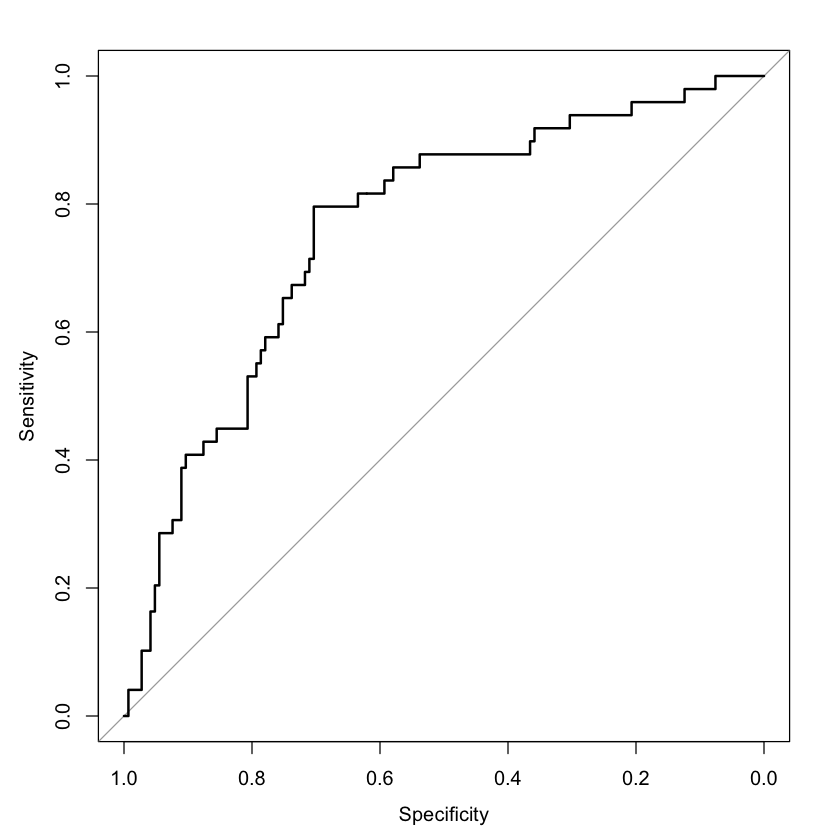

In [ ]:
par(bg = "white")
roc(truth_class, pred_prob, plot = TRUE)

In [ ]:
roc_obj <- roc(truth_class, pred_prob)
cc <- coords(roc_obj, "best", best.method="youden")
youden_index = cc$threshold
youden_index

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 0.3128844

In [ ]:
pred_class <- rep(0, nrow(test_df))
pred_class[pred_prob>=youden_index]<-1
truth <- test_df$PD
xtab <- table(pred_class, truth)
xtab

          truth
pred_class   0   1
         0 102  10
         1  43  39

In [ ]:
sensitivity(xtab)
specificity(xtab)
confusionMatrix(xtab)[3]$overall[1][['Accuracy']]

[1] 0.7034483

[1] 0.7959184

[1] 0.7268041

In [ ]:
wal_result = data.frame(
    Approach = c("WAL"),
    # Accuracy = confusionMatrix(xtab)[3]$overall[1][['Accuracy']],
    Bal_Accuracy = confusionMatrix(xtab)[4]$byClass[['Balanced Accuracy']],
    Sensitivity = c(sensitivity(xtab)),
    Specificity = c(specificity(xtab)),
    F1 = confusionMatrix(xtab)[4]$byClass[['F1']],
    AUC = c(auc(truth_class, pred_prob))
)
wal_result

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Approach,Bal_Accuracy,Sensitivity,Specificity,F1,AUC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WAL,0.7496833,0.7034483,0.7959184,0.7937743,0.7605911


# Experimental Result

In [ ]:
exp_result = rbind(full_result, aic_result, wal_result)
exp_result

Approach,Bal_Accuracy,Sensitivity,Specificity,F1,AUC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Full,0.7394792,0.7034483,0.7755102,0.7906977,0.7681914
AIC,0.7394792,0.7034483,0.7755102,0.7906977,0.7714286
WAL,0.7496833,0.7034483,0.7959184,0.7937743,0.7605911


Wald's test wins AIC.

# Final Model (Best Model by All data)

In [ ]:
full_model = glm(
    PD ~ .,
    family = binomial(link = "logit"),
    data = new_df
)

In [ ]:
final_model = glm(
    PD ~ PCP + TEL + CAM + CRA + DUR + SAV + INS + CCE + FRE,
    family = binomial(link = "logit"),
    data = new_df
)
summary(final_model)


Call:
glm(formula = PD ~ PCP + TEL + CAM + CRA + DUR + SAV + INS + 
    CCE + FRE, family = binomial(link = "logit"), data = new_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7626  -0.8157  -0.4815   0.9314   2.5707  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.430e-01  4.557e-01   1.411 0.158187    
PCP          9.183e-01  2.653e-01   3.461 0.000537 ***
TEL         -3.238e-01  1.711e-01  -1.892 0.058486 .  
CAM         -1.423e+00  1.720e-01  -8.273  < 2e-16 ***
CRA          7.570e-05  3.817e-05   1.983 0.047321 *  
DUR          2.746e-02  8.276e-03   3.319 0.000905 ***
SAV         -6.804e-01  1.693e-01  -4.020 5.83e-05 ***
INS         -4.627e-02  1.550e-02  -2.985 0.002839 ** 
CCE          3.462e-01  1.994e-01   1.736 0.082549 .  
FRE         -5.555e-01  2.000e-01  -2.777 0.005481 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Nu

### Diagnostic

In [ ]:
hosmerlem(new_df$PD, final_model$fitted.values)

X^2        Df   P(>Chi) 
5.4888126 8.0000000 0.7042791

In [ ]:
pchisq(deviance(final_model)-deviance(full_model), df = 15, lower=F)

[1] 0.2282124

In [ ]:
# quasi-likelihood
est.phi <- function(glmobj) {
    sum(residuals(glmobj, type="pearson")^2)/df.residual(glmobj)
}
est.phi(final_model)

[1] 1.028182

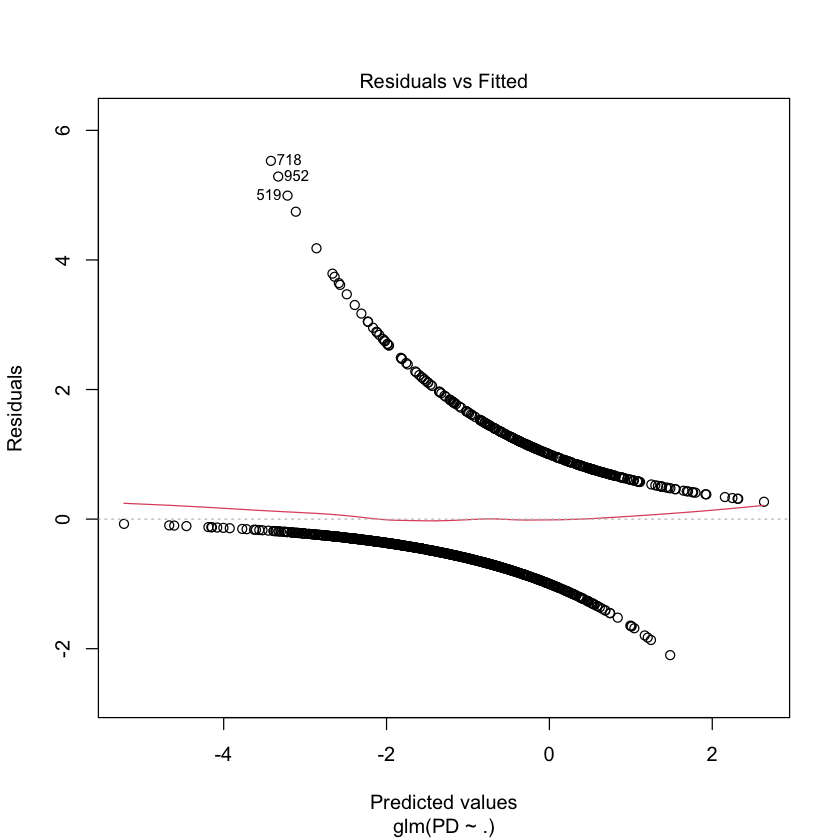

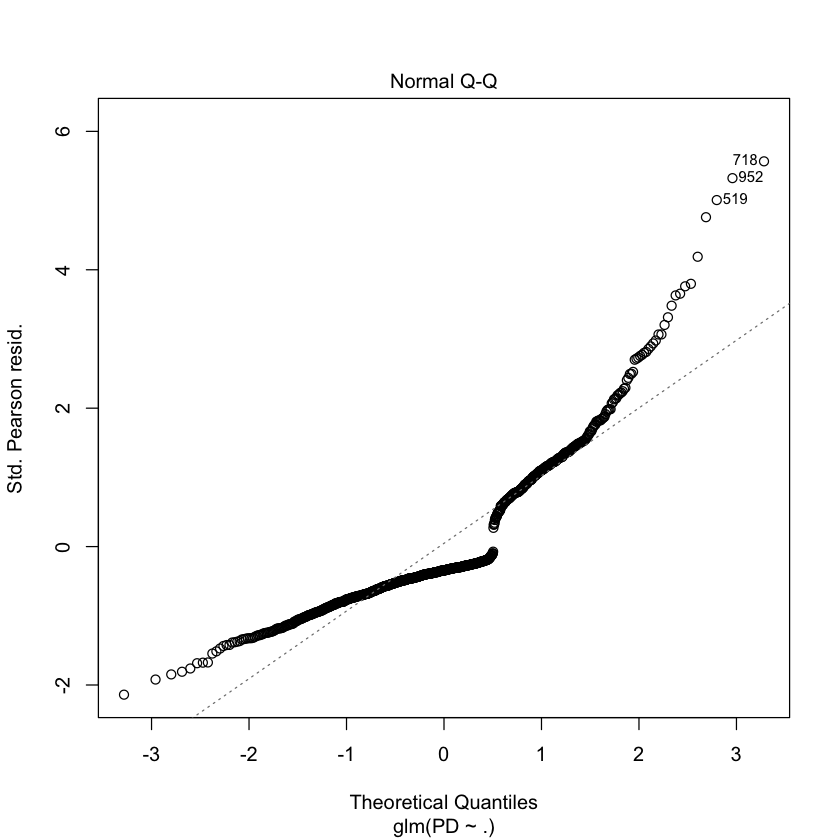

In [ ]:
par(bg="white")
plot(full_model, 1)
plot(full_model, 2)